In [1]:
# Mount Drive to access BRISC dataset files
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install required packages
!pip install torch torchvision numpy opencv-python tqdm PyMaxflow

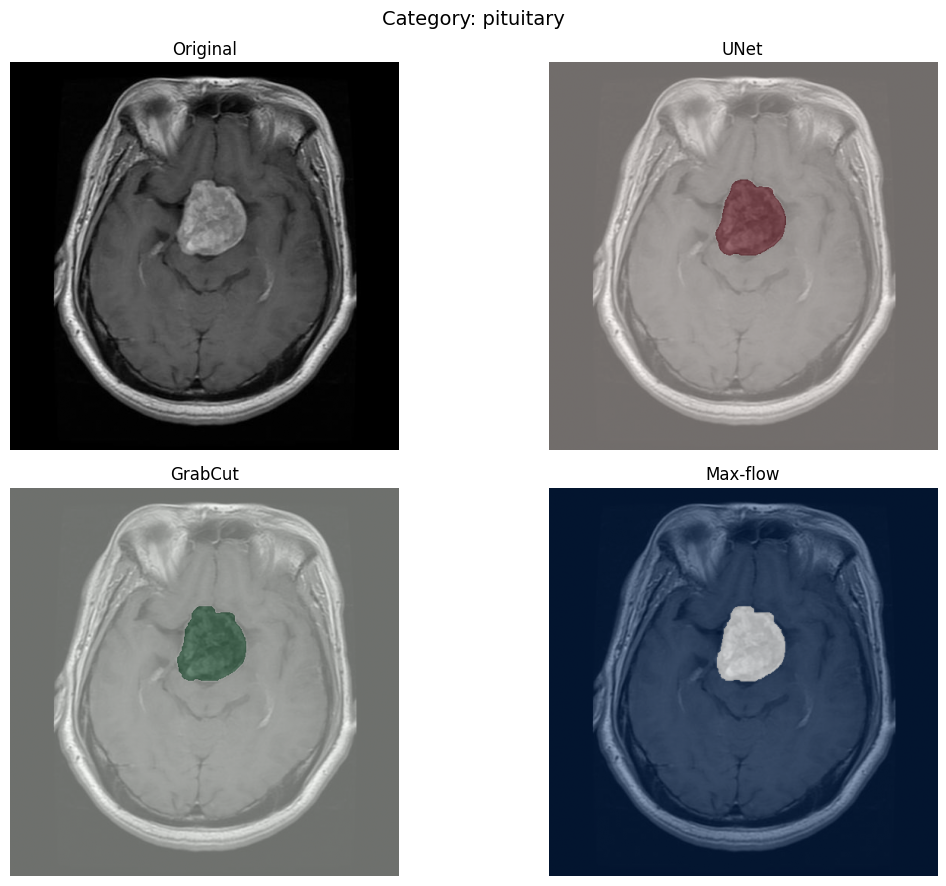

In [5]:
import cv2
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

# ---------- Your UNet definition (unchanged) ----------
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.dec4 = CBR(1024 + 512, 512)
        self.dec3 = CBR(512 + 256, 256)
        self.dec2 = CBR(256 + 128, 128)
        self.dec1 = CBR(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = F.interpolate(center, scale_factor=2, mode='bilinear', align_corners=True)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        out = torch.sigmoid(self.final(d1))
        return out

# ---------- Device + load weights ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
state = torch.load('/content/drive/MyDrive/MINOR PROJECT FILES/BRISC_UNet.pth', map_location=torch.device('cpu'))
model.load_state_dict(state)
model.eval()

# ---------- Helper: forward to prob map at original size ----------
def unet_prob_map(image_path, model, device, in_size=256):
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    H, W = img_gray.shape[:2]
    inp = cv2.resize(img_gray, (in_size, in_size)).astype(np.float32) / 255.0
    inp_t = torch.from_numpy(inp)[None, None].to(device)
    with torch.no_grad():
        prob_small = model(inp_t).squeeze().float().cpu().numpy()
    prob = cv2.resize(prob_small, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    return img_gray, prob  # prob in [0,1]

# ---------- Option 1: GrabCut refinement (OpenCV) ----------
def grabcut_refine_from_prob(img_gray, prob, iters=5, t_bg=0.2, t_mid=0.5, t_fg=0.8):
    # 0: GC_BGD, 1: GC_FGD, 2: GC_PR_BGD, 3: GC_PR_FGD
    mask = np.full(img_gray.shape, cv2.GC_PR_BGD, dtype=np.uint8)
    sure_bg = prob <= t_bg
    sure_fg = prob >= t_fg
    pr_fg   = (prob >= t_mid) & (prob < t_fg)
    pr_bg   = (prob > t_bg) & (prob < t_mid)
    mask[sure_bg] = cv2.GC_BGD
    mask[sure_fg] = cv2.GC_FGD
    mask[pr_fg]   = cv2.GC_PR_FGD
    mask[pr_bg]   = cv2.GC_PR_BGD
    img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    cv2.grabCut(img_bgr, mask, None, bgdModel, fgdModel, iters, mode=cv2.GC_INIT_WITH_MASK)
    out = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)
    return (out * 255).astype(np.uint8)

# ---------- Option 2: Max-flow/min-cut refinement (PyMaxflow) ----------
# pip install PyMaxflow
import maxflow

def maxflow_refine_from_prob(img_gray, prob, lam=25.0, sigma=10.0):
    H, W = img_gray.shape
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((H, W))

    # Unaries
    eps = 1e-6
    D_fg = -np.log(np.clip(prob, eps, 1.0)).astype(np.float32)
    D_bg = -np.log(np.clip(1.0 - prob, eps, 1.0)).astype(np.float32)
    g.add_grid_tedges(nodeids, D_bg, D_fg)

    # Start with uniform 4-neighborhood edges (von Neumann) and then modulate with contrast weights
    # First, add a base connectivity with unit weights; symmetric creates undirected edges
    g.add_grid_edges(nodeids, weights=1, structure=None, symmetric=True)  # 4-connected base [web:10]

    # Now add contrast-sensitive edges orientation-wise using valid shapes for weights
    imgf = img_gray.astype(np.float32)

    # Horizontal edges: weights shape must match the centers where structure connects (H, W-1)
    diff_h = imgf[:, 1:] - imgf[:, :-1]
    w_h = lam * np.exp(-(diff_h**2) / (2 * sigma**2)).astype(np.float32)
    # Build a structure that connects a pixel to its right neighbor.
    # For add_grid_edges, weights must match the grid of centers; shift-pad to H×W with zeros at last col.
    w_h_full = np.zeros((H, W), dtype=np.float32)
    w_h_full[:, :-1] = w_h
    structure_right = np.array([[0, 0, 0],
                                [0, 0, 1],
                                [0, 0, 0]], dtype=np.int32)
    g.add_grid_edges(nodeids, weights=w_h_full, structure=structure_right, symmetric=True)  # [web:10]

    # Vertical edges: weights shape (H-1, W) -> pad bottom row to H×W
    diff_v = imgf[1:, :] - imgf[:-1, :]
    w_v = lam * np.exp(-(diff_v**2) / (2 * sigma**2)).astype(np.float32)
    w_v_full = np.zeros((H, W), dtype=np.float32)
    w_v_full[:-1, :] = w_v
    structure_down = np.array([[0, 0, 0],
                               [0, 0, 0],
                               [0, 1, 0]], dtype=np.int32)
    g.add_grid_edges(nodeids, weights=w_v_full, structure=structure_down, symmetric=True)  # [web:10]

    g.maxflow()
    seg = g.get_grid_segments(nodeids)
    mask = np.where(seg, 255, 0).astype(np.uint8)
    return mask


# ---------- Run on one image and visualize 2×2 ----------
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0025.jpg'
save_dir = '/content/drive/MyDrive/OUTPUT'
os.makedirs(save_dir, exist_ok=True)
import os

def infer_category_from_path(image_path):
    # expects path/.../<category>/<filename>.jpg
    cat = os.path.basename(os.path.dirname(image_path))
    return cat  # 'meningioma', 'glioma', 'pituitary', or 'no_tumor'



img_gray, prob = unet_prob_map(image_path, model, device, in_size=256)
H, W = prob.shape
pmax = float(prob.max())
fg_frac = float((prob > 0.5).mean())
no_tumor = (pmax < 0.5) or (fg_frac < 0.001)  # adjust as needed

if no_tumor:
    # Save only the original and show a single panel
    cv2.imwrite(f'{save_dir}/{base}_orig.png', img_gray)
    plt.figure(figsize=(5,5))
    plt.imshow(img_gray, cmap='gray'); plt.axis('off')
    plt.title('No tumor detected')
    plt.show()
else:
    # Proceed with masks and 2×2 panel
    unet_mask = (prob > 0.5).astype(np.uint8) * 255
    grabcut_mask = grabcut_refine_from_prob(img_gray, prob, iters=5, t_bg=0.2, t_mid=0.5, t_fg=0.8)
    img_gray_d = cv2.medianBlur(img_gray, 3)
    maxflow_mask = maxflow_refine_from_prob(img_gray_d, prob, lam=25.0, sigma=10.0)

    # Save and visualize 2×2 as before
    #cv2.imwrite(f'{save_dir}/{base}_unet.png', unet_mask)
    #cv2.imwrite(f'{save_dir}/{base}_grabcut.png', grabcut_mask)
    #cv2.imwrite(f'{save_dir}/{base}_maxflow.png', maxflow_mask)

    category = infer_category_from_path(image_path)  # or classifier output
    fig, axs = plt.subplots(2,2, figsize=(12,9))
    fig.suptitle(f'Category: {category}', fontsize=14)  # figure-level title [web:125]

    axs[0,0].imshow(img_gray, cmap='gray'); axs[0,0].set_title('Original'); axs[0,0].axis('off')
    axs[0,1].imshow(img_gray, cmap='gray'); axs[0,1].imshow(unet_mask, cmap='Reds', alpha=0.45)
    axs[0,1].set_title('UNet'); axs[0,1].axis('off')
    axs[1,0].imshow(img_gray, cmap='gray'); axs[1,0].imshow(grabcut_mask, cmap='Greens', alpha=0.45)
    axs[1,0].set_title('GrabCut'); axs[1,0].axis('off')
    axs[1,1].imshow(img_gray, cmap='gray'); axs[1,1].imshow(maxflow_mask, cmap='Blues', alpha=0.45)
    axs[1,1].set_title('Max-flow'); axs[1,1].axis('off')
    plt.tight_layout(); plt.show()

    #plt.figure(figsize=(12,9))
    #plt.subplot(2,2,1); plt.imshow(img_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
    #plt.subplot(2,2,2); plt.imshow(img_gray, cmap='gray'); plt.imshow(unet_mask, cmap='Reds'); plt.title('UNet (0.5 thr)'); plt.axis('off')
    #plt.subplot(2,2,3); plt.imshow(img_gray, cmap='gray'); plt.imshow(unet_mask, cmap='Greens'); plt.title('GrabCut refined'); plt.axis('off')
    #plt.subplot(2,2,4); plt.imshow(img_gray, cmap='gray'); plt.imshow(unet_mask, cmap='plasma'); plt.title('Max-flow refined'); plt.axis('off')
    #plt.tight_layout(); plt.show()




